# Fit and compare orientation tuning curves

Our goal is to compare hue tuning properties of a give neuron across artificial and natural conditions. 

- For artificial condition, we simply fit a non-paramteric tuning curve as a density estimate of the spike count as a function of hue angle. We treat this as the **artificial tuning curve**. See **Section A**.

For natural conditions, it is difficult to estimate the presented hue from the fixated patch due to well-known issues of color constancy and color contrast. To this end, we take two different approaches. 

- First, we build a model based on the circular hue-histogram of the patch (along with nuisance variables). To this model, we present artificial hue patches encoded as a one-hot-vector corresponding to the histogram of a flat hue map, and treat the model prediction as the **natural tuning curve**. See **Section B**.


- Second, we build a model based on transfer learning from a pre-trained neural network (**VGG16**). We train separate Poisson gradient boosted regression models for four different pre-trained neural network codebooks: the last convolutional layer (**L5**), the two fully-connected layers (**L6**, **L7**) and the softmax layer (**L8**). We then present artificial hue patches (inputs encoded as RGB pixels) and compute the model predictions. We refer to these as the **synthetic tuning curve**. See **Section B**.

We then compare these tuning curves using a circular version of earth-mover's distance. See **Section C**.

## Imports

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# compute
import numpy as np
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
import V4pyutils as V4

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Load merged sessions

### Filenames

In [3]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']
data_M3.head()

Animal                         Natural                           Hue  \
7      M3  Ro150125_s83a_FreeViewPic_0004  Ro150126_s83a_huecircle_0003   
8      M3  Ro150125_s83a_FreeViewPic_0005  Ro150126_s83a_huecircle_0003   
9      M3  Ro150127_s84a_FreeViewPic_0001  Ro150127_s84a_huecircle_0003   
10     M3  Ro150128_s85a_FreeViewPic_0001  Ro150128_s85a_huecircle_0003   
11     M3  Ro150129_s86a_FreeViewPic_0001  Ro150129_s86a_huecircle_0003   

                                  Ori                            RF  
7   Ro150126_s83a_v4fv_orituning_0002  Ro150126_s83a_rfMapping_0001  
8   Ro150126_s83a_v4fv_orituning_0002  Ro150126_s83a_rfMapping_0001  
9   Ro150127_s84a_v4fv_orituning_0002  Ro150127_s84a_rfMapping_0001  
10  Ro150128_s85a_v4fv_orituning_0002  Ro150128_s85a_rfMapping_0001  
11  Ro150129_s86a_v4fv_orituning_0002  Ro150129_s86a_rfMapping_0001

### All sessions

In [4]:
df = pd.read_pickle('../02-preprocessed_data/merged_art_data_across_sessions_orientation')

# Correct for orientation angle > 180 deg.
df['predictors.ori'] = np.where(df['predictors.ori'] >= 180.0,
                                df['predictors.ori'] - 180.0,
                                df['predictors.ori'])
df['predictors.ori_prev'] = np.where(df['predictors.ori_prev'] >= 180.0,
                                     df['predictors.ori_prev'] - 180.0,
                                     df['predictors.ori_prev'])
df.head()


predictors.onset_times  predictors.offset_times  predictors.col  \
0               17.794800                18.079600           521.0   
1               18.398067                18.690333           590.0   
2               19.011833                19.299400           670.0   
3               19.618200                19.909533           641.0   
4               20.248333                20.545200           621.0   

   predictors.row  predictors.ori  predictors.ori_prev  predictors.stim_dur  \
0           521.0           112.0               -999.0             0.284800   
1           590.0           157.0                112.0             0.292267   
2           670.0            67.0                157.0             0.287567   
3           641.0            67.0                 67.0             0.291333   
4           621.0           112.0                 67.0             0.296867   

   predictors.off_to_onset_times  spikes.0101  spikes.0201       ...        \
0                    -999.000000          NaN          NaN       ...         
1                       0.318467          NaN          NaN       ...         
2                       0.321500          NaN          NaN       ...         
3                       0.318800          NaN          NaN       ...         
4                       0.338800          NaN          NaN       ...         

   spikes.9002  spikes.9100  spikes.9102  spikes.9200  spikes.9202  \
0          NaN         11.0          NaN         11.0          NaN   
1          NaN         11.0          NaN         11.0          NaN   
2          NaN          8.0          NaN          8.0          NaN   
3          NaN          7.0          NaN          7.0          NaN   
4          NaN          2.0          NaN          2.0          NaN   

   spikes.9300  spikes.9400  spikes.9600  \
0          NaN          NaN          3.0   
1          NaN          NaN          2.0   
2          NaN          NaN          4.0   
3          NaN          NaN          1.0   
4          NaN          NaN          3.0   

                                        session.name  session.number  
0  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  
1  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  
2  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  
3  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  
4  ../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...               0  

[5 rows x 117 columns]

### Merging table

In [5]:
df_neurons = pd.read_pickle('../02-preprocessed_data/data_to_combine_across_sessions')
df_neurons.head(10)

name        art_sessions  \
0  spikes.0101              [2, 3]   
1  spikes.0301              [8, 9]   
2  spikes.0500           [3, 4, 5]   
3  spikes.0500           [4, 5, 6]   
4  spikes.0600        [2, 3, 4, 5]   
5  spikes.0700        [0, 1, 2, 3]   
6  spikes.0700              [4, 5]   
7  spikes.0700              [7, 8]   
8  spikes.0900  [0, 1, 2, 3, 4, 5]   
9  spikes.0900     [3, 4, 5, 6, 7]   

                                       art_filenames     nat_sessions  \
0  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...              [4]   
1  [Ro150211_s88a_huecircle_0003, Ro150212_289a_h...         [11, 12]   
2  [Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...           [5, 6]   
3  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...        [6, 7, 8]   
4  [Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...        [4, 5, 6]   
5  [Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...        [2, 3, 4]   
6  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...              [6]   
7  [Ro150211_s88a_huecircle_0003, Ro150211_s88a_h...             [10]   
8  [Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...  [2, 3, 4, 5, 6]   
9  [Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...  [5, 6, 7, 8, 9]   

                                       nat_filenames  
0                   [Ro150129_s86a_FreeViewPic_0001]  
1  [Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a...  
2  [Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a...  
3  [Ro150210_s87a_FreeViewPic_manyimage_0004, Ro1...  
4  [Ro150129_s86a_FreeViewPic_0001, Ro150129_s86a...  
5  [Ro150127_s84a_FreeViewPic_0001, Ro150128_s85a...  
6         [Ro150210_s87a_FreeViewPic_manyimage_0004]  
7                   [Ro150213_s90a_FreeViewPic_0004]  
8  [Ro150127_s84a_FreeViewPic_0001, Ro150128_s85a...  
9  [Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a...

## A. Artificial tuning curves

### Fit models for each neuron

0 spikes.0101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0724950106919
...runnning cv-fold 2 of 2
pseudo_R2:  0.0037771834604
pseudo_R2_cv: 0.038136 (+/- 0.024295)
------------------------------------------------------------



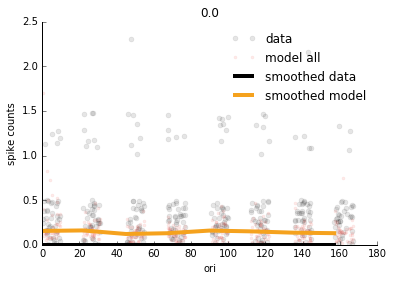

1 spikes.0301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0877322467138
...runnning cv-fold 2 of 2
pseudo_R2:  0.0765589331445
pseudo_R2_cv: 0.082146 (+/- 0.003950)
------------------------------------------------------------



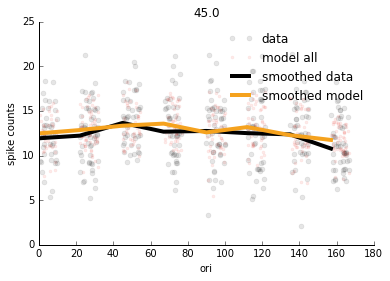

2 spikes.0500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.164305084384
...runnning cv-fold 2 of 3
pseudo_R2:  0.185169099142
...runnning cv-fold 3 of 3
pseudo_R2:  0.232529942377
pseudo_R2_cv: 0.084465 (+/- 0.102171)
------------------------------------------------------------



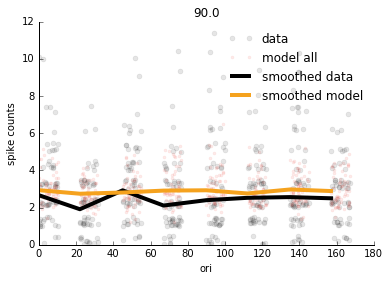

3 spikes.0500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.280337090405
...runnning cv-fold 2 of 3
pseudo_R2:  0.345007791955
...runnning cv-fold 3 of 3
pseudo_R2:  -0.603770973221
pseudo_R2_cv: -0.179700 (+/- 0.227372)
------------------------------------------------------------



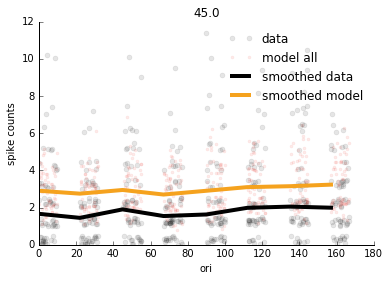

4 spikes.0600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.189620184279
...runnning cv-fold 2 of 4
pseudo_R2:  -0.68671000369
...runnning cv-fold 3 of 4
pseudo_R2:  -0.586268690375
...runnning cv-fold 4 of 4
pseudo_R2:  -0.235377462502
pseudo_R2_cv: -0.424494 (+/- 0.107778)
------------------------------------------------------------



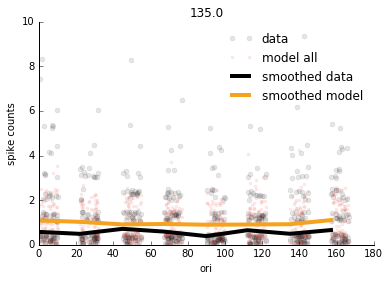

5 spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -1.45192108005
...runnning cv-fold 2 of 4
pseudo_R2:  -0.0367941412168
...runnning cv-fold 3 of 4
pseudo_R2:  -0.498076603716
...runnning cv-fold 4 of 4
pseudo_R2:  -0.713556556887
pseudo_R2_cv: -0.675087 (+/- 0.255404)
------------------------------------------------------------



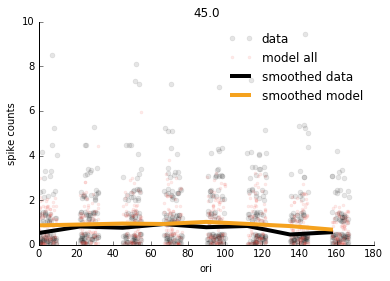

6 spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0870555174964
...runnning cv-fold 2 of 2
pseudo_R2:  -0.432382854793
pseudo_R2_cv: -0.259719 (+/- 0.122092)
------------------------------------------------------------



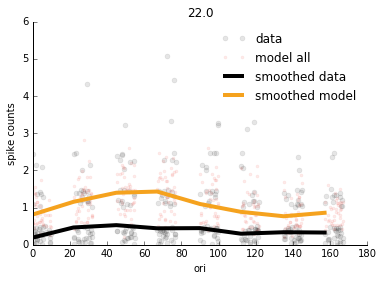

7 spikes.0700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.126012424528
...runnning cv-fold 2 of 2
pseudo_R2:  0.269698757398
pseudo_R2_cv: 0.197856 (+/- 0.050801)
------------------------------------------------------------



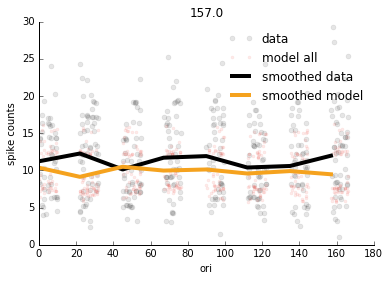

8 spikes.0900
9 spikes.0900
10 spikes.0900
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.776952854828
...runnning cv-fold 2 of 3
pseudo_R2:  -0.74641725828
...runnning cv-fold 3 of 3
pseudo_R2:  0.0274804975639
pseudo_R2_cv: -0.498630 (+/- 0.214904)
------------------------------------------------------------



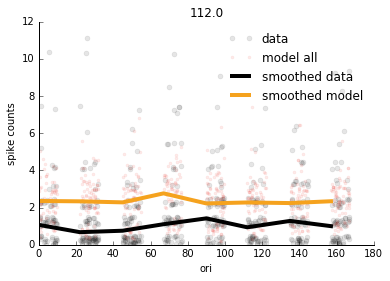

11 spikes.1100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.291073675856
...runnning cv-fold 2 of 2
pseudo_R2:  0.197879229223
pseudo_R2_cv: 0.244476 (+/- 0.032949)
------------------------------------------------------------



12 spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.302602025302
...runnning cv-fold 2 of 2
pseudo_R2:  0.333151340536
pseudo_R2_cv: 0.317877 (+/- 0.010801)
------------------------------------------------------------



13 spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.278837624492
...runnning cv-fold 2 of 2
pseudo_R2:  0.119475464261
pseudo_R2_cv: 0.199157 (+/- 0.056343)
------------------------------------------------------------



14 spikes.1400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0831240055059
...runnning cv-fold 2 of 3
pseudo_R2:  -0.452447558053
...runnning cv-fold 3 of 3
pseudo_R2:  0.210758602272
pseudo_R2_cv: -0.052855 (+/- 0.165884)
------------------------------------------------------------



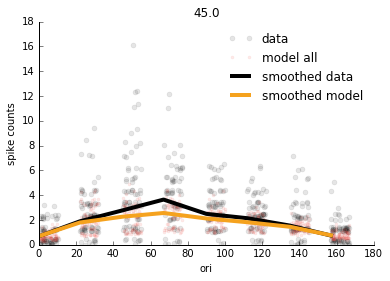

15 spikes.1500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0209801535929
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0881734610112
...runnning cv-fold 3 of 3
pseudo_R2:  -0.0573306209033
pseudo_R2_cv: -0.041508 (+/- 0.026526)
------------------------------------------------------------



16 spikes.1500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0196113544067
...runnning cv-fold 2 of 2
pseudo_R2:  0.124580463478
pseudo_R2_cv: 0.052485 (+/- 0.050980)
------------------------------------------------------------



17 spikes.1701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0932847425608
...runnning cv-fold 2 of 2
pseudo_R2:  -0.506753797221
pseudo_R2_cv: -0.300019 (+/- 0.146183)
------------------------------------------------------------



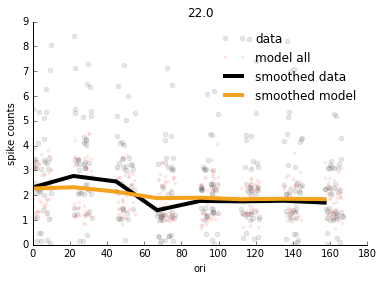

18 spikes.2101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0724556558133
...runnning cv-fold 2 of 2
pseudo_R2:  0.0491246107562
pseudo_R2_cv: 0.060790 (+/- 0.008249)
------------------------------------------------------------



19 spikes.2501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0011475883928
...runnning cv-fold 2 of 2
pseudo_R2:  -0.374678996875
pseudo_R2_cv: -0.187913 (+/- 0.132063)
------------------------------------------------------------



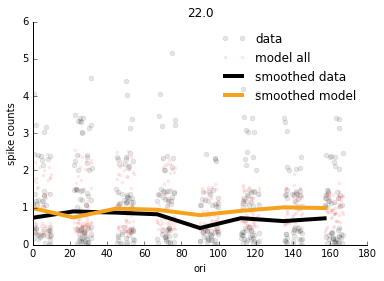

20 spikes.2801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.3529756993
...runnning cv-fold 2 of 2
pseudo_R2:  0.23909461349
pseudo_R2_cv: 0.296035 (+/- 0.040263)
------------------------------------------------------------



21 spikes.2901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.114461939044
...runnning cv-fold 2 of 2
pseudo_R2:  -0.457862793877
pseudo_R2_cv: -0.171700 (+/- 0.202347)
------------------------------------------------------------



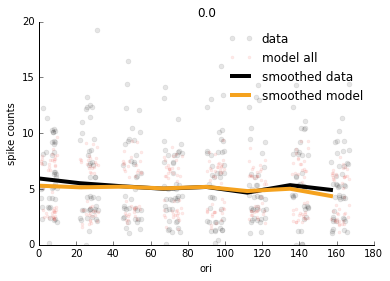

22 spikes.2901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.119583949203
...runnning cv-fold 2 of 2
pseudo_R2:  0.0907171242449
pseudo_R2_cv: 0.105151 (+/- 0.010206)
------------------------------------------------------------



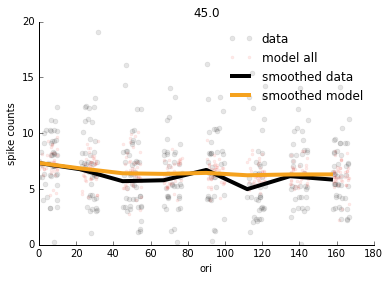

23 spikes.3201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.254823353466
...runnning cv-fold 2 of 2
pseudo_R2:  -0.102035041004
pseudo_R2_cv: 0.076394 (+/- 0.126168)
------------------------------------------------------------



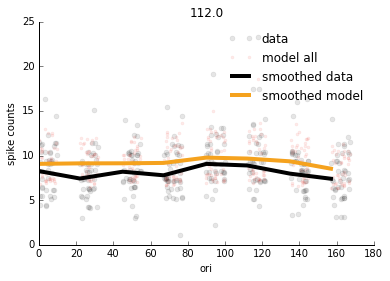

24 spikes.3201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.078174020701
...runnning cv-fold 2 of 2
pseudo_R2:  0.140430987995
pseudo_R2_cv: 0.109303 (+/- 0.022011)
------------------------------------------------------------



25 spikes.3401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.248082781912
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0846256489608
pseudo_R2_cv: 0.081729 (+/- 0.117630)
------------------------------------------------------------



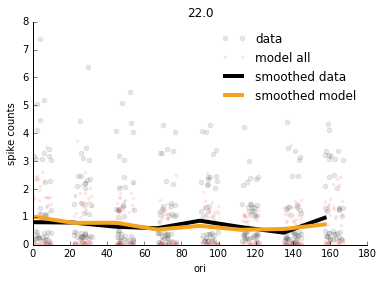

26 spikes.3401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.410757400993
...runnning cv-fold 2 of 2
pseudo_R2:  -0.355106777261
pseudo_R2_cv: 0.027825 (+/- 0.270774)
------------------------------------------------------------



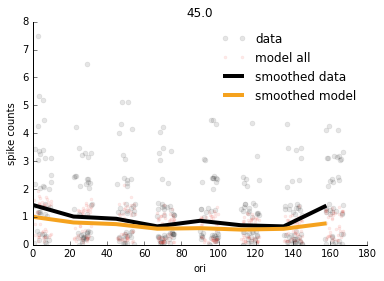

27 spikes.3601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.194168889695
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0815340024768
pseudo_R2_cv: -0.137851 (+/- 0.039822)
------------------------------------------------------------



28 spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.283608645579
...runnning cv-fold 2 of 2
pseudo_R2:  -0.111972540285
pseudo_R2_cv: -0.197791 (+/- 0.060683)
------------------------------------------------------------



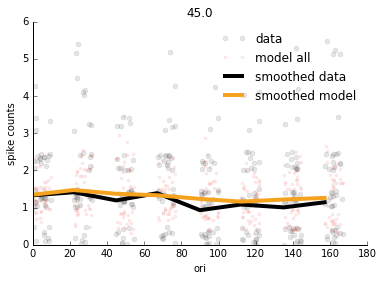

29 spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.291437386134
...runnning cv-fold 2 of 4
pseudo_R2:  -1.03313116467
...runnning cv-fold 3 of 4
pseudo_R2:  -0.774955973183
...runnning cv-fold 4 of 4
pseudo_R2:  0.0870967480572
pseudo_R2_cv: -0.357388 (+/- 0.279456)
------------------------------------------------------------



30 spikes.3701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0978678951447
...runnning cv-fold 2 of 3
pseudo_R2:  0.288349604626
...runnning cv-fold 3 of 3
pseudo_R2:  -0.292650351832
pseudo_R2_cv: -0.034056 (+/- 0.139399)
------------------------------------------------------------



31 spikes.3801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.215243458216
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0704861017198
pseudo_R2_cv: -0.142865 (+/- 0.051179)
------------------------------------------------------------



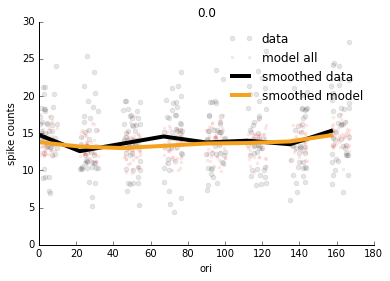

32 spikes.3801
33 spikes.3901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.182107686645
...runnning cv-fold 2 of 2
pseudo_R2:  0.866456630255
pseudo_R2_cv: 0.342174 (+/- 0.370723)
------------------------------------------------------------



34 spikes.3901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0436879714547
...runnning cv-fold 2 of 2
pseudo_R2:  0.182577431191
pseudo_R2_cv: 0.113133 (+/- 0.049105)
------------------------------------------------------------



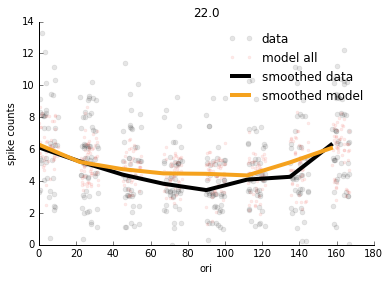

35 spikes.4301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.847167615962
...runnning cv-fold 2 of 2
pseudo_R2:  -0.239750501507
pseudo_R2_cv: -0.543459 (+/- 0.214754)
------------------------------------------------------------



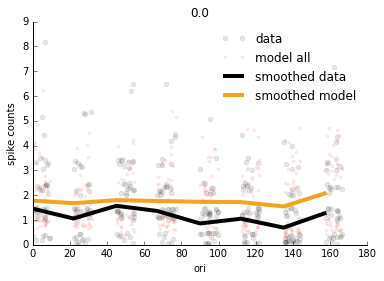

36 spikes.4301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0454199507902
...runnning cv-fold 2 of 2
pseudo_R2:  -0.190981141199
pseudo_R2_cv: -0.072781 (+/- 0.083580)
------------------------------------------------------------



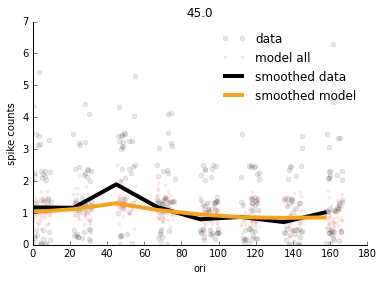

37 spikes.4401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.277180236865
...runnning cv-fold 2 of 4
pseudo_R2:  -1.53815727478
...runnning cv-fold 3 of 4
pseudo_R2:  0.0774004514806
...runnning cv-fold 4 of 4
pseudo_R2:  -0.456100285106
pseudo_R2_cv: -0.548509 (+/- 0.301385)
------------------------------------------------------------



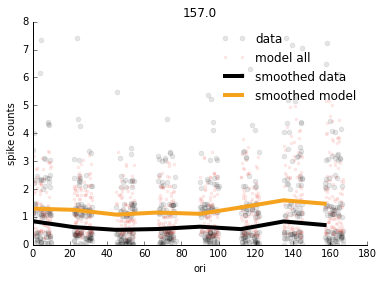

38 spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.131620694761
...runnning cv-fold 2 of 2
pseudo_R2:  0.0809738840252
pseudo_R2_cv: 0.106297 (+/- 0.017906)
------------------------------------------------------------



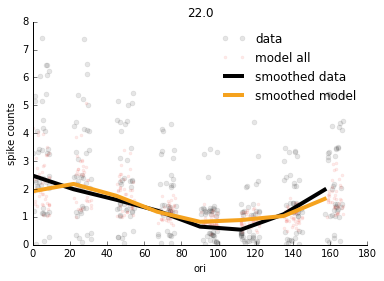

39 spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  0.216654784958
...runnning cv-fold 2 of 4
pseudo_R2:  0.344060865035
...runnning cv-fold 3 of 4
pseudo_R2:  0.20908554477
...runnning cv-fold 4 of 4
pseudo_R2:  0.277200386275
pseudo_R2_cv: 0.261750 (+/- 0.027181)
------------------------------------------------------------



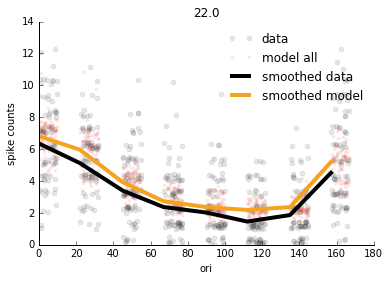

40 spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.083203131759
...runnning cv-fold 2 of 2
pseudo_R2:  0.23701309728
pseudo_R2_cv: 0.160108 (+/- 0.054380)
------------------------------------------------------------



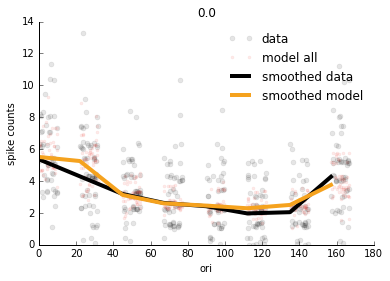

41 spikes.4501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.163990658324
...runnning cv-fold 2 of 2
pseudo_R2:  0.0700672799481
pseudo_R2_cv: 0.117029 (+/- 0.033207)
------------------------------------------------------------



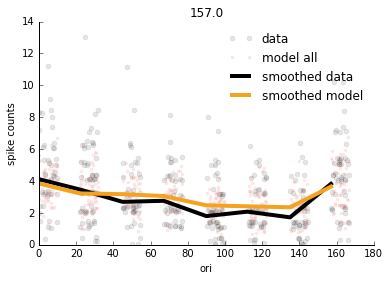

42 spikes.4701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0697345820816
...runnning cv-fold 2 of 3
pseudo_R2:  0.0914385747376
...runnning cv-fold 3 of 3
pseudo_R2:  0.109522459754
pseudo_R2_cv: 0.090232 (+/- 0.009391)
------------------------------------------------------------



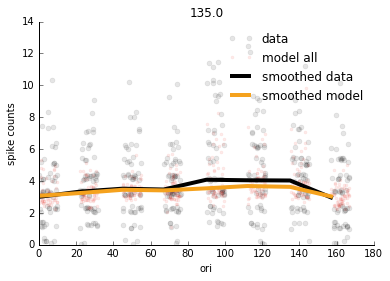

43 spikes.4701
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0832209012877
...runnning cv-fold 2 of 2
pseudo_R2:  0.105169467923
pseudo_R2_cv: 0.010974 (+/- 0.066606)
------------------------------------------------------------



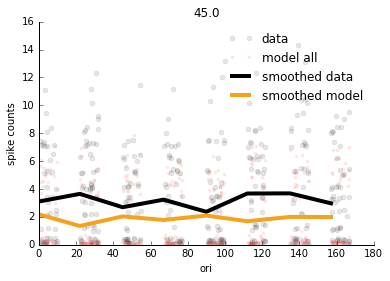

44 spikes.4901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0672770018983
...runnning cv-fold 2 of 2
pseudo_R2:  -0.131864126399
pseudo_R2_cv: -0.099571 (+/- 0.022835)
------------------------------------------------------------



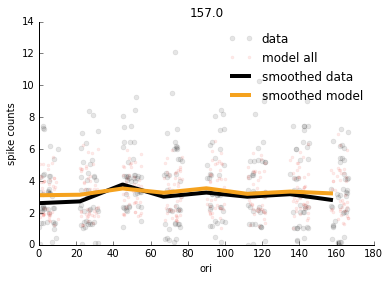

45 spikes.4901
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.000919282604188
...runnning cv-fold 2 of 2
pseudo_R2:  0.0725594554664
pseudo_R2_cv: 0.035820 (+/- 0.025979)
------------------------------------------------------------



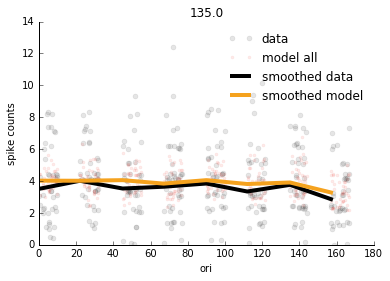

46 spikes.5101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0217408586584
...runnning cv-fold 2 of 3
pseudo_R2:  0.0648480554043
...runnning cv-fold 3 of 3
pseudo_R2:  0.158025650194
pseudo_R2_cv: 0.067044 (+/- 0.042381)
------------------------------------------------------------



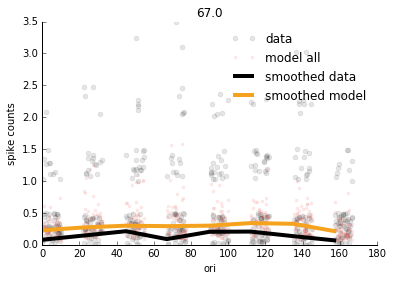

47 spikes.5101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0345918377425
...runnning cv-fold 2 of 2
pseudo_R2:  0.118661777299
pseudo_R2_cv: 0.042035 (+/- 0.054183)
------------------------------------------------------------



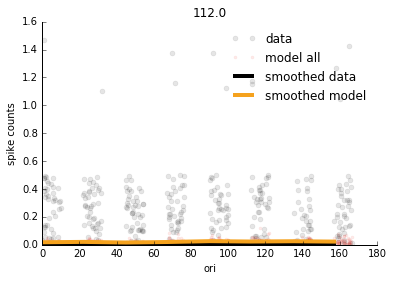

48 spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -1.24063062352
...runnning cv-fold 2 of 3
pseudo_R2:  0.0440619268996
...runnning cv-fold 3 of 3
pseudo_R2:  -0.578676154803
pseudo_R2_cv: -0.591748 (+/- 0.302852)
------------------------------------------------------------



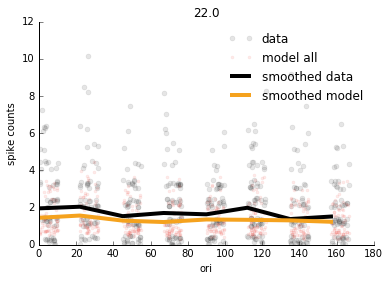

49 spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0887584042597
...runnning cv-fold 2 of 2
pseudo_R2:  0.0763350497199
pseudo_R2_cv: 0.082547 (+/- 0.004392)
------------------------------------------------------------



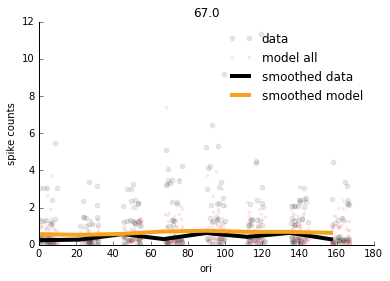

50 spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0306694765698
...runnning cv-fold 2 of 2
pseudo_R2:  0.115725833793
pseudo_R2_cv: 0.073198 (+/- 0.030072)
------------------------------------------------------------



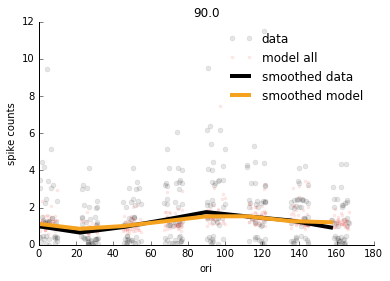

51 spikes.5201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.188931546722
...runnning cv-fold 2 of 2
pseudo_R2:  0.112634762803
pseudo_R2_cv: -0.038148 (+/- 0.106620)
------------------------------------------------------------



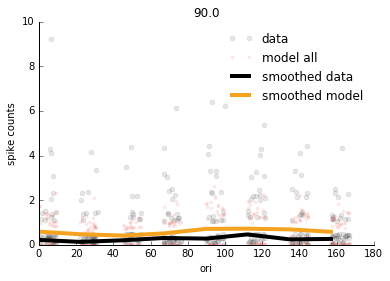

52 spikes.5301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  -0.146994300732
...runnning cv-fold 2 of 5
pseudo_R2:  -0.0114229342847
...runnning cv-fold 3 of 5
pseudo_R2:  -0.244155613591
...runnning cv-fold 4 of 5
pseudo_R2:  -0.218631808309
...runnning cv-fold 5 of 5
pseudo_R2:  -0.264576887458
pseudo_R2_cv: -0.177156 (+/- 0.041099)
------------------------------------------------------------



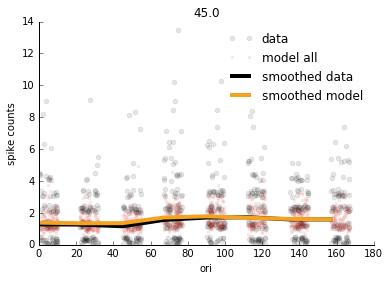

53 spikes.5301
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0204624944644
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0167765747172
pseudo_R2_cv: -0.018620 (+/- 0.001303)
------------------------------------------------------------



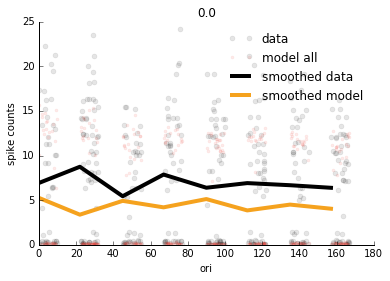

54 spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0927614466163
...runnning cv-fold 2 of 2
pseudo_R2:  -0.130359438411
pseudo_R2_cv: -0.111560 (+/- 0.013293)
------------------------------------------------------------



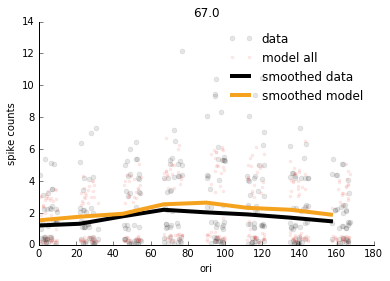

55 spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.215487543927
...runnning cv-fold 2 of 4
pseudo_R2:  0.383348645848
...runnning cv-fold 3 of 4
pseudo_R2:  -1.54782032605
...runnning cv-fold 4 of 4
pseudo_R2:  -0.732483313344
pseudo_R2_cv: -0.528111 (+/- 0.354442)
------------------------------------------------------------



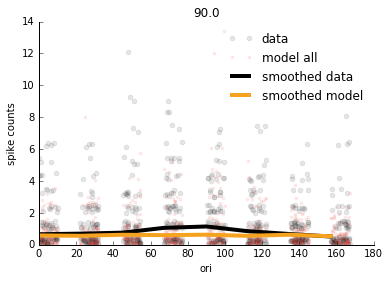

56 spikes.5401
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.285967161069
...runnning cv-fold 2 of 2
pseudo_R2:  -0.00718782530471
pseudo_R2_cv: -0.146577 (+/- 0.098563)
------------------------------------------------------------



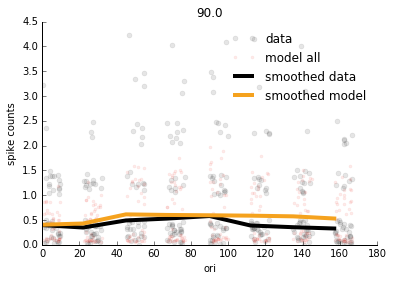

57 spikes.5501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.102789800931
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0974941895684
pseudo_R2_cv: -0.100142 (+/- 0.001872)
------------------------------------------------------------



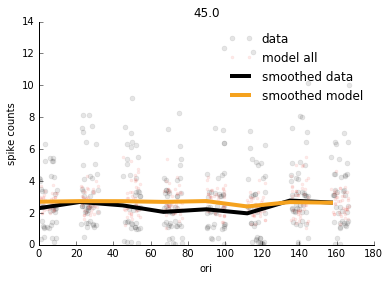

58 spikes.5501
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.163134676238
...runnning cv-fold 2 of 2
pseudo_R2:  -0.125365462097
pseudo_R2_cv: -0.144250 (+/- 0.013353)
------------------------------------------------------------



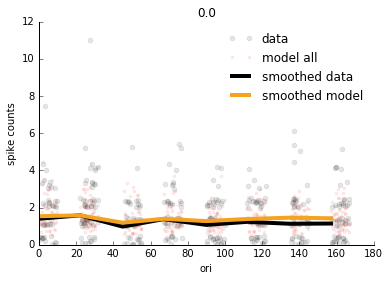

59 spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.084677751252
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0908798599841
pseudo_R2_cv: -0.003101 (+/- 0.062069)
------------------------------------------------------------



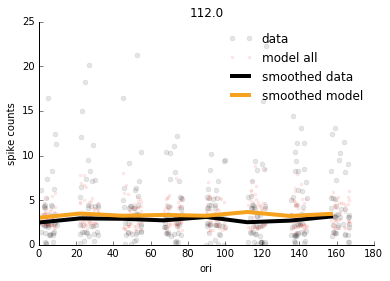

60 spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.291445413124
...runnning cv-fold 2 of 2
pseudo_R2:  -0.14842685321
pseudo_R2_cv: -0.219936 (+/- 0.050565)
------------------------------------------------------------



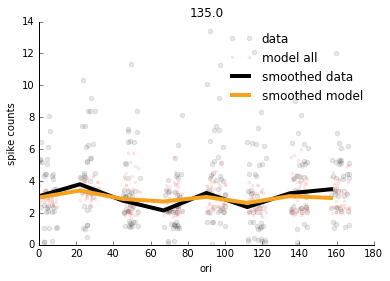

61 spikes.5601
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.089254427845
...runnning cv-fold 2 of 2
pseudo_R2:  -0.00828461231918
pseudo_R2_cv: -0.048770 (+/- 0.028627)
------------------------------------------------------------



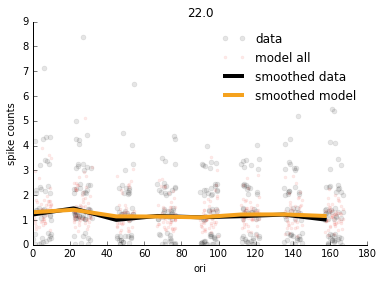

62 spikes.5801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 4
pseudo_R2:  -0.281078557053
...runnning cv-fold 2 of 4
pseudo_R2:  -0.230047005824
...runnning cv-fold 3 of 4
pseudo_R2:  -1.45423285678
...runnning cv-fold 4 of 4
pseudo_R2:  -0.0626884994381
pseudo_R2_cv: -0.507012 (+/- 0.276406)
------------------------------------------------------------



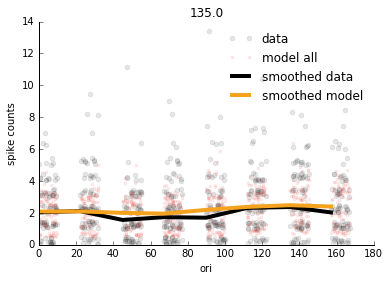

63 spikes.5801
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  0.0753167736136
...runnning cv-fold 2 of 5
pseudo_R2:  -0.198402901289
...runnning cv-fold 3 of 5
pseudo_R2:  -2.51881425704
...runnning cv-fold 4 of 5
pseudo_R2:  -0.431296118368
...runnning cv-fold 5 of 5
pseudo_R2:  0.219288613257
pseudo_R2_cv: -0.570782 (+/- 0.446972)
------------------------------------------------------------



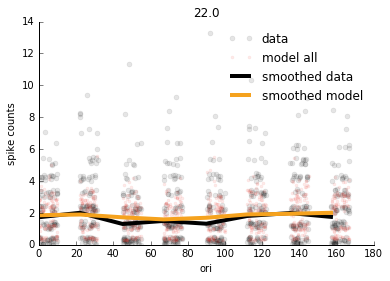

64 spikes.6101
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.411815905944
...runnning cv-fold 2 of 2
pseudo_R2:  0.0991497840686
pseudo_R2_cv: -0.156333 (+/- 0.180654)
------------------------------------------------------------



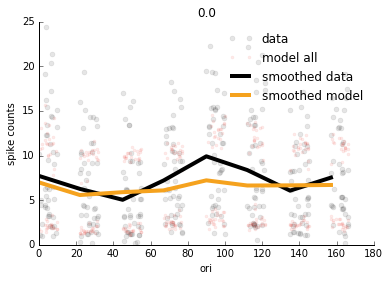

65 spikes.6201
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.000597301253075
...runnning cv-fold 2 of 2
pseudo_R2:  0.100689956673
pseudo_R2_cv: 0.050046 (+/- 0.035810)
------------------------------------------------------------



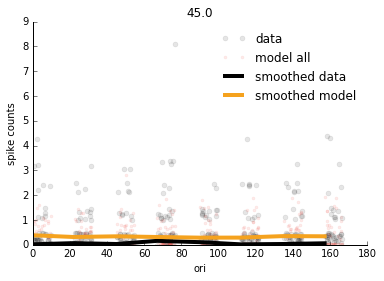

66 spikes.6400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.339141659736
...runnning cv-fold 2 of 2
pseudo_R2:  -0.100644090158
pseudo_R2_cv: -0.219893 (+/- 0.084322)
------------------------------------------------------------



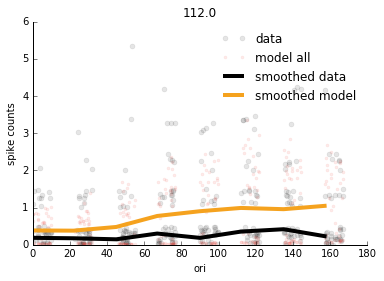

67 spikes.6400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.27245798951
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0633327550685
pseudo_R2_cv: -0.167895 (+/- 0.073937)
------------------------------------------------------------



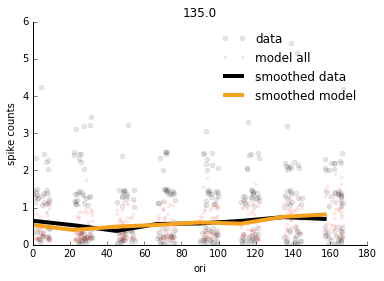

68 spikes.7300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0396377810734
...runnning cv-fold 2 of 2
pseudo_R2:  0.222716825634
pseudo_R2_cv: 0.131177 (+/- 0.064728)
------------------------------------------------------------



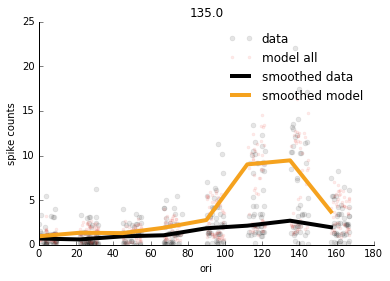

69 spikes.7500
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.190837330027
...runnning cv-fold 2 of 2
pseudo_R2:  -0.178219245591
pseudo_R2_cv: -0.184528 (+/- 0.004461)
------------------------------------------------------------



70 spikes.7800
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.274858601009
...runnning cv-fold 2 of 2
pseudo_R2:  -1.18291916579
pseudo_R2_cv: -0.728889 (+/- 0.321048)
------------------------------------------------------------



71 spikes.8000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.159577468957
...runnning cv-fold 2 of 2
pseudo_R2:  0.142814679469
pseudo_R2_cv: 0.151196 (+/- 0.005927)
------------------------------------------------------------



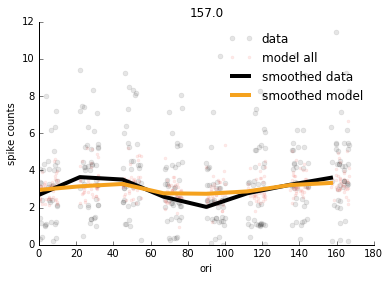

72 spikes.8100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.462921811967
...runnning cv-fold 2 of 2
pseudo_R2:  0.339101250541
pseudo_R2_cv: 0.401012 (+/- 0.043777)
------------------------------------------------------------



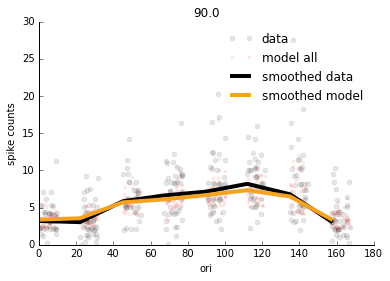

73 spikes.8300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.114925104755
...runnning cv-fold 2 of 2
pseudo_R2:  -0.0392026575805
pseudo_R2_cv: -0.077064 (+/- 0.026772)
------------------------------------------------------------



74 spikes.8300
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  0.0133971419213
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0511510652689
...runnning cv-fold 3 of 3
pseudo_R2:  0.128449793319
pseudo_R2_cv: 0.030232 (+/- 0.042887)
------------------------------------------------------------



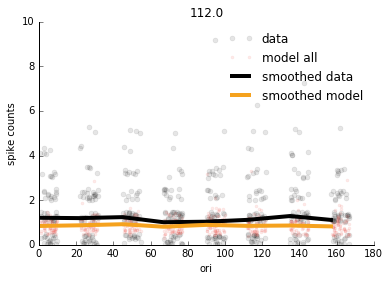

75 spikes.8400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0404683092482
...runnning cv-fold 2 of 2
pseudo_R2:  0.0943380743563
pseudo_R2_cv: 0.026935 (+/- 0.047661)
------------------------------------------------------------



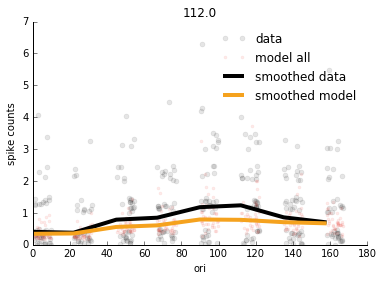

76 spikes.8400
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0482628696926
...runnning cv-fold 2 of 3
pseudo_R2:  0.171998426488
...runnning cv-fold 3 of 3
pseudo_R2:  -0.462140779771
pseudo_R2_cv: -0.112802 (+/- 0.151773)
------------------------------------------------------------



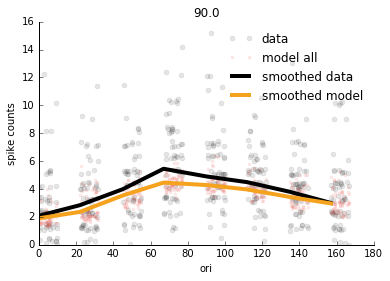

77 spikes.8600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0128327466
...runnning cv-fold 2 of 2
pseudo_R2:  -0.208937271366
pseudo_R2_cv: -0.098052 (+/- 0.078408)
------------------------------------------------------------



78 spikes.8700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0490217945737
...runnning cv-fold 2 of 2
pseudo_R2:  0.0691449617292
pseudo_R2_cv: 0.010062 (+/- 0.041778)
------------------------------------------------------------



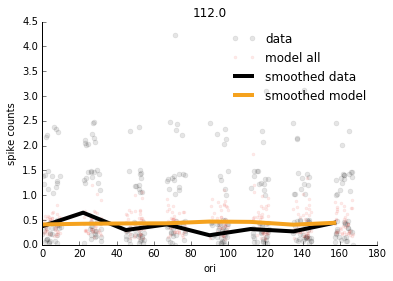

79 spikes.8700
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 5
pseudo_R2:  0.0490782722503
...runnning cv-fold 2 of 5
pseudo_R2:  0.0572155221977
...runnning cv-fold 3 of 5
pseudo_R2:  -0.222725935554
...runnning cv-fold 4 of 5
pseudo_R2:  0.0400100348618
...runnning cv-fold 5 of 5
pseudo_R2:  -0.0243923032759
pseudo_R2_cv: -0.020163 (+/- 0.047097)
------------------------------------------------------------



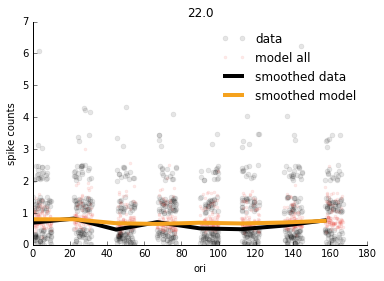

80 spikes.8800
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  -0.0882975697343
...runnning cv-fold 2 of 2
pseudo_R2:  -0.309925282985
pseudo_R2_cv: -0.199111 (+/- 0.078357)
------------------------------------------------------------



81 spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.00500774748243
...runnning cv-fold 2 of 3
pseudo_R2:  0.115564173838
...runnning cv-fold 3 of 3
pseudo_R2:  -0.0244084803809
pseudo_R2_cv: 0.028716 (+/- 0.035749)
------------------------------------------------------------



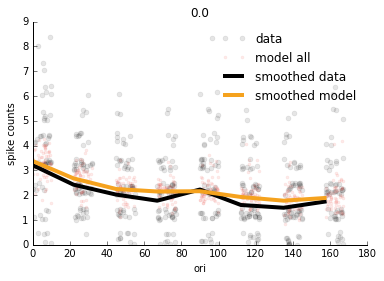

82 spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0269083115646
...runnning cv-fold 2 of 2
pseudo_R2:  -0.346141758264
pseudo_R2_cv: -0.159617 (+/- 0.131893)
------------------------------------------------------------



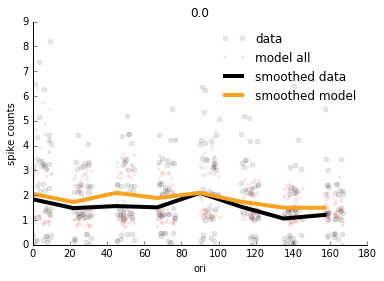

83 spikes.9000
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0536919566924
...runnning cv-fold 2 of 3
pseudo_R2:  -0.0156191258915
...runnning cv-fold 3 of 3
pseudo_R2:  0.00295415370265
pseudo_R2_cv: -0.022119 (+/- 0.013613)
------------------------------------------------------------



84 spikes.9100
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.540657307078
...runnning cv-fold 2 of 2
pseudo_R2:  0.52529390738
pseudo_R2_cv: 0.532976 (+/- 0.005432)
------------------------------------------------------------



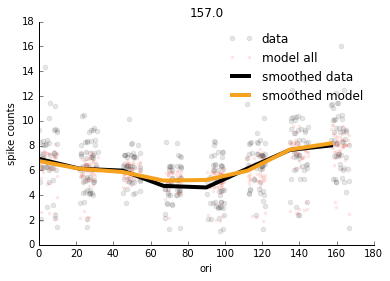

85 spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0174573646181
...runnning cv-fold 2 of 2
pseudo_R2:  0.167453721842
pseudo_R2_cv: 0.092456 (+/- 0.053032)
------------------------------------------------------------



86 spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 3
pseudo_R2:  -0.0778869429713
...runnning cv-fold 2 of 3
pseudo_R2:  0.294296417524
...runnning cv-fold 3 of 3
pseudo_R2:  0.241126546904
pseudo_R2_cv: 0.152512 (+/- 0.094891)
------------------------------------------------------------



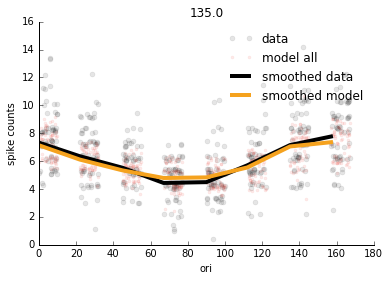

87 spikes.9200
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.513303666841
...runnning cv-fold 2 of 2
pseudo_R2:  0.469968423918
pseudo_R2_cv: 0.491636 (+/- 0.015321)
------------------------------------------------------------



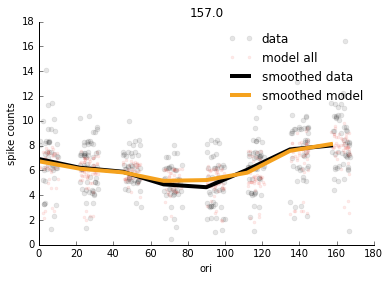

88 spikes.9600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.11100842874
...runnning cv-fold 2 of 2
pseudo_R2:  0.857147415918
pseudo_R2_cv: 0.484078 (+/- 0.263800)
------------------------------------------------------------



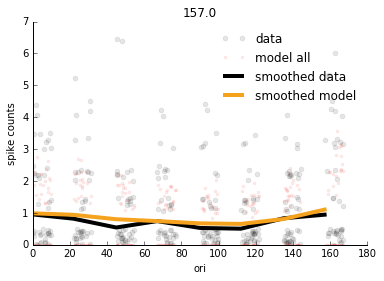

89 spikes.9600
running model 1 of 1: all
------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.845539695865
...runnning cv-fold 2 of 2
pseudo_R2:  0.007423546813
pseudo_R2_cv: 0.426482 (+/- 0.296319)
------------------------------------------------------------



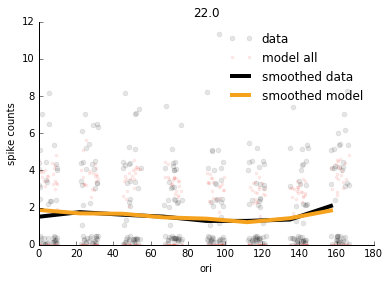

In [6]:
df_fits_art_orientation_all = pd.DataFrame(columns=['art_orientation_model'])

Models_art = dict()
#Models_art['hue'] = dict()
#Models_art['hue']['covariates'] = ['predictors.hue']

Models_art['all'] = dict()
Models_art['all']['covariates'] = ['predictors.ori', 
                                   'predictors.col', 
                                   'predictors.row', 
                                   'predictors.ori_prev', 
                                   'predictors.stim_dur', 
                                   'predictors.off_to_onset_times']

for neuron_id, neuron_name in enumerate(df_neurons['name']):
    
    print neuron_id, neuron_name
    
    # Extract session numbers
    art_sessions_of_interest = df_neurons.loc[neuron_id]['art_sessions']
    
    # Grab relevant data
    df_sessions_of_interest = df.loc[df['session.number'].isin(art_sessions_of_interest)]
    
    # Labels and number of folds for stratified CV
    labels = df_sessions_of_interest['session.number']
    n_cv = np.size(np.unique(art_sessions_of_interest))
    
    # Get spike counts
    Y = df_sessions_of_interest[neuron_name].values
    
    # If they are nan, skip the neuron
    if(np.any(np.isnan(Y))):
        temp = dict()
        temp['ori'] = []
        temp['spike_counts'] = []
        temp['predicted_spike_counts'] = []
        temp['pseudo_R2'] = []
        df_fits_art_orientation_all.loc[neuron_id] = [temp]
        continue
        
    # Loop through models
    for model_number, model in enumerate(Models_art):
        print 'running model %d of %d: %s' % (model_number+1, len(Models_art), model)
        
        # Get covariates
        X = df_sessions_of_interest[Models_art[model]['covariates']].values        
        
        # Fit models
        Yt_hat, pseudo_R2 = V4.fit_cv(X, Y,
                                      stratify_by_labels=labels,
                                      n_cv=n_cv,
                                      algorithm='XGB_poisson',
                                      verbose=2)
        
        Models_art[model]['Yt_hat'], Models_art[model]['pseudo_R2'] = Yt_hat, pseudo_R2    
        print ''

        x_data = df_sessions_of_interest['predictors.ori'].values
        y_data = Y
        xlabel = 'ori'
        V4.plot_xy(x_data=x_data, y_data=y_data,
                   y_model=Models_art[model]['Yt_hat'],
                   lowess_frac=0.3, xlabel=xlabel, model_name=model, 
                   x_jitter_level=10., y_jitter_level=0.5)
        plt.title((X[np.argmax(Models_art[model]['Yt_hat'])])[0])
        #plt.ylim([0,4])
        plt.show()
        temp = dict()
        temp['ori'] = df_sessions_of_interest['predictors.ori'].values
        temp['spike_counts'] = Y
        temp['predicted_spike_counts'] = Yt_hat   
        temp['pseudo_R2'] = pseudo_R2
        
    df_fits_art_orientation_all.loc[neuron_id] = [temp]

In [7]:
len(df_fits_art_orientation_all)

90

### Visualize example neuron

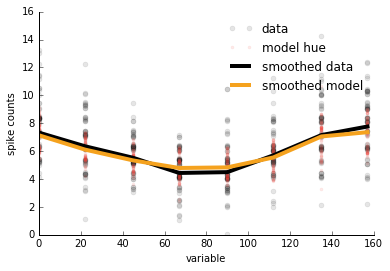

In [8]:
neuron_id = 86
V4.plot_xy(x_data=df_fits_art_orientation_all.loc[neuron_id]['art_orientation_model']['ori'], 
           y_data=df_fits_art_orientation_all.loc[neuron_id]['art_orientation_model']['spike_counts'], 
           y_model=df_fits_art_orientation_all.loc[neuron_id]['art_orientation_model']['predicted_spike_counts'])

## B. Synthetic tuning curves for grating stimuli [VGG16]

### Instantiate vgg models

In [7]:
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=0)
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=1)
vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
                                 n_pops=3)
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=5)


### Extract art features for gratings

In [8]:
np.unique(df['predictors.ori'])

array([   0.,   22.,   45.,   67.,   90.,  112.,  135.,  157.])

In [9]:
def make_sine_grating(n_pixels=224, theta=0, spatial_freq=0.03, phase=0):
    
    # Design the grating
    [x, y] = np.meshgrid(np.arange(n_pixels), np.arange(n_pixels))
    theta = 180. - theta
    x_theta = x * np.cos(theta / 180. * np.pi) + y * np.sin(theta / 180. * np.pi)
    y_theta = -x * np.sin(theta / 180. * np.pi) + y * np.cos(theta / 180. * np.pi)
    grating = (1. + np.cos(2 * np.pi * spatial_freq * x_theta + phase / 180. * np.pi))/ 2.
    
    # Make it into an image
    G = np.zeros((n_pixels, n_pixels, 3))
    G[:, :, 0] = grating * 255.
    G[:, :, 1] = grating * 255.
    G[:, :, 2] = grating * 255.    
    return np.uint8(G)

In [10]:
ori = 180. * np.random.rand(1000,1)
art_features = dict()
# Extract vgg features for oriented gratings
Xgrating_vgg = list()
for a, ang in enumerate(ori):
    G = make_sine_grating(theta=ang, phase=0.)
    G_for_vgg = V4.prepare_image_for_vgg(G)
    Xgrating_vgg.append(np.squeeze(vgg_model.predict(G_for_vgg)))
Xgrating_vgg = np.array(Xgrating_vgg)

In [91]:
Xgrating_vgg.shape

(1000, 4096)

### Simulate a cosine tuned neuron

In [11]:
from pyglmnet import GLM
glm = GLM(distr='poissonexp')
covars = np.concatenate((np.cos(2. * ori / 180. * np.pi), np.sin(2. * ori / 180. * np.pi)), axis=1)
Y = glm.simulate(0.001, [0.05, 0.95], covars)
Y.shape

(1000,)

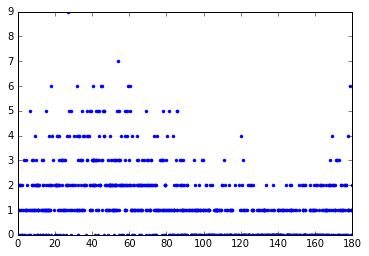

In [12]:
plt.plot(ori, Y, '.')
plt.show()

In [16]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.layers.core import Lambda
from keras.models import model_from_json
from keras.layers.advanced_activations import ELU

from keras.regularizers import l2, l1l2
def KerasGLM(input_dim, hidden_dim):
    model = Sequential() 
    # Add a dense exponential layer with hidden_dim outputs
    model.add(Dense(hidden_dim, input_shape=(input_dim,), init='glorot_normal', activation='relu'))
    model.add(Dropout(0.5))
    
    # Add a dense exponential layer with 1 output
    model.add(Dense(1, input_shape=(hidden_dim,), activation='softplus', 
                    init='glorot_normal', W_regularizer=l1l2(l1=0.1, l2=0.1)))
    #model.add(Lambda(lambda x: np.exp(x)))
    model.compile(loss='poisson', optimizer='rmsprop')
    return model

#---------------------------------------
def keras_GLM_poisson(Xr, Yr, Xt, model, batch_size, epochs):
    #keras_glm_model = KerasGLM(input_dim=Xr.shape[1], hidden_dim=100)
    keras_glm_model.fit(Xr, Yr, batch_size=batch_size, nb_epoch=epochs)
    Yt = keras_glm_model.predict(Xt)
    return Yt

In [26]:
#from sklearn.cross_validation import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X = Xgrating_vgg
ori_train = ori[0:800]
ori_test = ori[800:1000]

X_train = X[0:800, :]
X_test = X[800:1000, :]

Y_train = Y[0:800]
Y_test = Y[800:1000]


In [37]:
keras_glm_model = KerasGLM(input_dim=X.shape[1], hidden_dim=100)
Y_train_hat = keras_GLM_poisson(X_train, Y_train, X_train, keras_glm_model, batch_size=32, epochs=50)
Y_test_hat = keras_glm_model.predict(X_test)

pseudo_R2_train = V4.poisson_pseudo_R2(np.squeeze(Y_train), np.squeeze(Y_train_hat), np.mean(Y_train))
pseudo_R2_test = V4.poisson_pseudo_R2(np.squeeze(Y_test), np.squeeze(Y_test_hat), np.mean(Y_train))
pseudo_R2_train, pseudo_R2_test

Epoch 1/50
800/800 [==============================] - 0s - loss: 104604108.0375     
Epoch 2/50
800/800 [==============================] - 0s - loss: 20.6064     
Epoch 3/50
800/800 [==============================] - 0s - loss: 20.5318     
Epoch 4/50
800/800 [==============================] - 0s - loss: 20.4623     
Epoch 5/50
800/800 [==============================] - 0s - loss: 20.4035     
Epoch 6/50
800/800 [==============================] - 0s - loss: 20.3500     
Epoch 7/50
800/800 [==============================] - 0s - loss: 20.3074     
Epoch 8/50
800/800 [==============================] - 0s - loss: 20.2709     
Epoch 9/50
800/800 [==============================] - 0s - loss: 20.2345     
Epoch 10/50
800/800 [==============================] - 0s - loss: 20.1934     
Epoch 11/50
800/800 [==============================] - 0s - loss: 20.1453     
Epoch 12/50
800/800 [==============================] - 0s - loss: 20.0884     
Epoch 13/50
800/800 [==============================] -

(0.22180309982304136, 0.24072752391526797)

In [38]:
Y_train_hat.shape

(800, 1)

In [39]:
covars_train = covars[0:800]
covars_test = covars[800:1000]

glm.fit(covars_train, Y_train)
Y_test_hat2 = glm[-1].predict(covars_test)

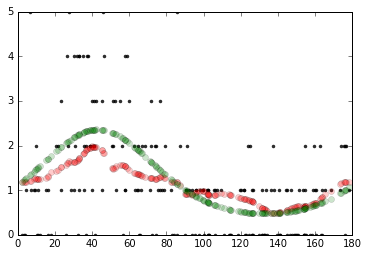

In [40]:
plt.plot(ori_test, Y_test, 'k.', alpha=0.8)
plt.plot(ori_test, Y_test_hat, 'ro', alpha=0.2)
plt.plot(ori_test, Y_test_hat2, 'go', alpha=0.2)
plt.show()

### Fit VGG models to simulated neuron

In [157]:
#-----------------
# Get covariates
#-----------------
X = Xgrating_vgg
#X = covars

#-------------
# Fit models
#-------------    
#V4.fit(X, Y, algorithm='XGB_poisson')    

# Cross-validated predictions and scores
Yt_hat, image_model['pseudo_R2'] = V4.fit_cv(X, Y,
                                             stratify_by_labels=[],
                                             n_cv=n_cv,
                                             algorithm='XGB_poisson',
                                             verbose=2)
    

    

------------------------------------------------------------
...runnning cv-fold 1 of 2
pseudo_R2:  0.0246223672506
...runnning cv-fold 2 of 2
pseudo_R2:  0.0680196269258
pseudo_R2_cv: 0.046321 (+/- 0.015343)
------------------------------------------------------------


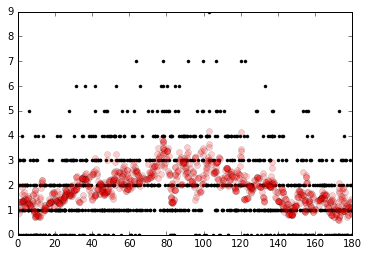

In [158]:
plt.plot(np.squeeze(ori), Y, 'k.')
plt.plot(np.squeeze(ori), Yt_hat, 'ro', alpha=0.2)
plt.show()

### Design artificial stimuli and compute convnet codebooks

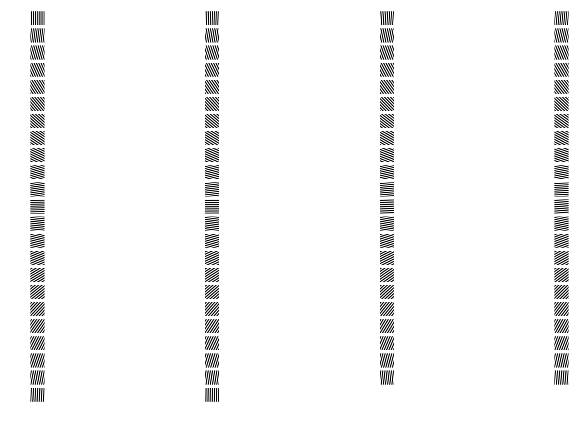

In [159]:
def make_sine_grating(n_pixels=224, theta=0, spatial_freq=0.03, phase=0):
    
    # Design the grating
    [x, y] = np.meshgrid(np.arange(n_pixels), np.arange(n_pixels))
    theta = 180. - theta
    x_theta = x * np.cos(theta / 180. * np.pi) + y * np.sin(theta / 180. * np.pi)
    y_theta = -x * np.sin(theta / 180. * np.pi) + y * np.cos(theta / 180. * np.pi)
    grating = (1. + np.cos(2 * np.pi * spatial_freq * x_theta + phase / 180. * np.pi))/ 2.
    
    # Make it into an image
    G = np.zeros((n_pixels, n_pixels, 3))
    G[:, :, 0] = grating * 255.
    G[:, :, 1] = grating * 255.
    G[:, :, 2] = grating * 255.    
    return np.uint8(G)


#angles = [0.,   22.,   45.,   67.,   90.,  112.,  135.,  157.]
angles = np.linspace(0., 179.0, num=90.)
#phases = 360. * np.random.rand(90)
phases = np.zeros(90)
plt.figure(figsize=(12,7))

# Extract vgg features for oriented gratings
Xgrating_vgg = list()
for a, ang in enumerate(angles):
    G = make_sine_grating(theta=angles[a], phase=phases[a])
    G_for_vgg = V4.prepare_image_for_vgg(G)
    Xgrating_vgg.append(np.squeeze(vgg_model.predict(G_for_vgg)))
    
    plt.subplot(23, 4, a + 1)
    plt.imshow(G, interpolation='none')
    plt.axis('off')
plt.show()
Xgrating_vgg = np.array(Xgrating_vgg)

In [161]:
plt.figure(figsize=(20,20))
u_start, u_end = 500, 600
for u in range(u_start, u_end):
    tune = Xgrating_vgg[:, u]
    if np.all(tune == 0):
        continue
    else:
        ax = plt.subplot(10, 10, u - u_start + 1)
        ax.plot(angles, Xgrating_vgg[:, u], 'b-', alpha=0.8)
        V4.simpleaxis(ax)
        plt.axis('off')
plt.show()

### Make predictions on artificial stimuli

In [20]:
df_predictions = pd.DataFrame(columns=['vggl6_orientation_prediction'])

# Loop through df_neurons
#for neuron_id, neuron_name in enumerate(df_neurons['name']):
for neuron_id in [12, 13, 14, 34, 38, 39, 40, 41, 72, 76, 77, 84, 85, 86, 87]:
    neuron_name = df_neurons.loc[neuron_id]['name']
    print neuron_name
    
    # Extract session numbers
    nat_sessions_of_interest = df_neurons.loc[neuron_id]['nat_sessions']
    
    # Grab relevant data
    nat_df_sessions_of_interest = nat_df.loc[nat_df['session.number'].isin(nat_sessions_of_interest) & \
                                             nat_df.index.isin(nat_features['accepted_indices'])]
    
    #-----------------
    # Get covariates
    #-----------------
    # Select a df of interest
    indices_of_interest = np.array(nat_df_sessions_of_interest.index)
    nat_features_of_interest = \
        nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]
    
    # Convert everything to array
    n_samples = len(nat_features_of_interest)
        
    # Non-image features
    n_features = np.shape(nat_features_of_interest['non_image_features'][nat_features_of_interest.index[0]].values)[0]
    non_image_features_array = np.zeros((n_samples, n_features))
    non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                           for k in nat_features_of_interest.index]
    for k in range(n_samples):
        non_image_features_array[k, :] = non_image_features_list[k]

    #----------------------------
    # Predict on grating stimuli
    #----------------------------
    
    #-------------
    # Joint model
    #-------------
    model = df_models.loc[neuron_id]['vggl6_model']['joint_model']['model']
    random_resample = np.random.randint(0, n_samples, Xgrating_vgg.shape[0])
    Xgrating_augment = np.concatenate((Xgrating_vgg, 
                                      non_image_features_array[random_resample, :]), 
                                      axis=1)
    Ygrating_hat_joint = model.predict(xgb.DMatrix(Xgrating_augment))
    
    #-------------
    # Image model
    #-------------
    model = df_models.loc[neuron_id]['vggl6_model']['image_model']['model']
    Ygrating_hat_image = model.predict(xgb.DMatrix(Xgrating_vgg))
    print ''
    
    # Accumulate everything for later
    temp = dict()
    temp['ori'] = angles
    temp['joint_predicted_spike_counts'] = Ygrating_hat_joint
    temp['image_predicted_spike_counts'] = Ygrating_hat_image
    df_predictions.loc[neuron_id] = [temp]
    

spikes.1400

spikes.1400

spikes.1400

spikes.3901

spikes.4501

spikes.4501

spikes.4501

spikes.4501

spikes.8100

spikes.8400

spikes.8600

spikes.9100

spikes.9200

spikes.9200

spikes.9200



In [21]:
plt.plot(df_predictions.loc[neuron_id]['vggl6_orientation_prediction']['ori'],
         df_predictions.loc[neuron_id]['vggl6_orientation_prediction']['joint_prediction'],
         'yo', alpha=0.5)
plt.plot(df_predictions.loc[neuron_id]['vggl6_orientation_prediction']['ori'],
         df_predictions.loc[neuron_id]['vggl6_orientation_prediction']['image_prediction'],
         'ro', alpha=0.5)
plt.show()

KeyError: 'joint_prediction'

### Accumulate model predictions in a data frame

In [22]:
df_results_all = df_neurons.merge(df_fits_art_orientation_all, left_index=True, right_index=True)
df_results_all = df_results_all.merge(df_models, left_index=True, right_index=True)
df_results_all = df_results_all.merge(df_predictions, left_index=True, right_index=True)
df_results_all.head()

name art_sessions  \
12  spikes.1400       [4, 5]   
13  spikes.1400       [6, 7]   
14  spikes.1400    [7, 8, 9]   
34  spikes.3901       [8, 9]   
38  spikes.4501       [0, 1]   

                                        art_filenames  nat_sessions  \
12  [Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...           [6]   
13  [Ro150210_s87a_huecircle_0003, Ro150211_s88a_h...           [9]   
14  [Ro150211_s88a_huecircle_0003, Ro150211_s88a_h...  [10, 11, 12]   
34  [Ro150211_s88a_huecircle_0003, Ro150212_289a_h...      [11, 12]   
38  [Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...           [2]   

                                        nat_filenames  \
12         [Ro150210_s87a_FreeViewPic_manyimage_0004]   
13        [Ro150212_289a_FreeViewPic_manyimages_0004]   
14  [Ro150213_s90a_FreeViewPic_0004, Ro150216_s91a...   
34  [Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a...   
38                   [Ro150127_s84a_FreeViewPic_0001]   

                                art_orientation_model  \
12  {u'pseudo_R2': [0.302602025302, 0.333151340536...   
13  {u'pseudo_R2': [0.278837624492, 0.119475464261...   
14  {u'pseudo_R2': [0.0831240055059, -0.4524475580...   
34  {u'pseudo_R2': [0.0436879714547, 0.18257743119...   
38  {u'pseudo_R2': [0.131620694761, 0.080973884025...   

                                          vggl6_model  \
12  {u'joint_model': {u'pseudo_R2': [0.18617537598...   
13  {u'joint_model': {u'pseudo_R2': [0.20193469662...   
14  {u'joint_model': {u'pseudo_R2': [-0.0778098642...   
34  {u'joint_model': {u'pseudo_R2': [-0.3167801110...   
38  {u'joint_model': {u'pseudo_R2': [0.03868715399...   

                         vggl6_orientation_prediction  
12  {u'image_predicted_spike_counts': [1.72044, 1....  
13  {u'image_predicted_spike_counts': [2.95855, 2....  
14  {u'image_predicted_spike_counts': [1.41011, 1....  
34  {u'image_predicted_spike_counts': [4.24086, 4....  
38  {u'image_predicted_spike_counts': [1.27621, 1....

### Save everything

In [23]:
df_results_all.to_pickle('../02-preprocessed_data/results_all')

## C. Compare tuning curves

In [155]:
df_results_all = pd.read_pickle('../02-preprocessed_data/results_all')

In [37]:
df_results_all = df_results_all.merge(df_models, left_index=True, right_index=True)
df_results_all = df_results_all.merge(df_predictions, left_index=True, right_index=True)
df_results_all.head()

vggl7_orientation_model
0  {u'pseudo_R2': [0.00543081642055, 0.0478237979...
1  {u'pseudo_R2': [0.0301254869447, 0.83585843611...
2  {u'pseudo_R2': [0.031788546228, -0.00110237685...
3  {u'pseudo_R2': [0.0427657408511, 0.07704605422...
4  {u'pseudo_R2': [0.0365010083199, -0.3785226784...

In [60]:
#df_results_all.to_pickle('../02-preprocessed_data/fits_all')

### Visualize single neuron tuning curves and pseudo-$R^2$s

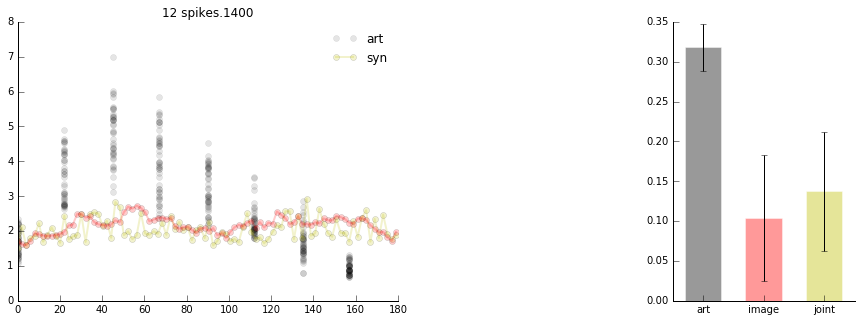

(art, syn): 0.306992


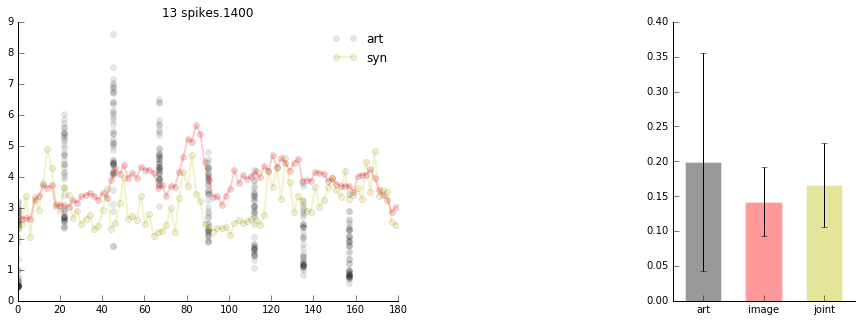

(art, syn): 0.113719


(art, syn): 0.122691


(art, syn): -0.631815


In [28]:
art_syn_corr = list()
        
art_pseudo_R2 = dict()
art_pseudo_R2['mean'] = list()
art_pseudo_R2['std'] = list()
art_model_name = 'art_orientation_model'

syn_pseudo_R2 = dict()
syn_pseudo_R2['mean'] = list()
syn_pseudo_R2['std'] = list()
syn_model_name = 'vggl6_model'
syn_model_prediction = 'vggl6_orientation_prediction'

art_entropy = list()
syn_entropy = list()

#for neuron_id, neuron_name in enumerate(df_results_all['name']):
for neuron_id in [12, 13, 14, 34, 38, 39, 40, 41, 72, 76, 77, 84, 85, 86, 87]:
    #neuron_id = 40
    #neuron_name = 'spikes.4501'
    neuron_name = df_neurons.loc[neuron_id]['name']
    if ((np.mean(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']) - \
         1.96 * np.std(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']) > 0.) & \
        (np.mean(df_results_all[art_model_name][neuron_id]['pseudo_R2']) - \
         1.96 * np.std(df_results_all[art_model_name][neuron_id]['pseudo_R2']) > 0.)):
    #if(True):
        plt.figure(figsize=(15,5))


        # Collect all pseudo R2s
        art_pseudo_R2['mean'].append(np.mean(df_results_all[art_model_name][neuron_id]['pseudo_R2']))
        art_pseudo_R2['std'].append(np.std(df_results_all[art_model_name][neuron_id]['pseudo_R2']))
        syn_pseudo_R2['mean'].append(np.mean(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']))
        syn_pseudo_R2['std'].append(np.std(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']))

        ax = plt.subplot(121)
        V4.simpleaxis(ax)

        # Fit a polynomial to the art tuning curve
        f_poly = np.poly1d(np.polyfit(df_results_all[art_model_name][neuron_id]['ori'], 
                  df_results_all[art_model_name][neuron_id]['predicted_spike_counts'],
                  5))        
        art_grating_ori = f_poly(df_results_all[syn_model_prediction][neuron_id]['ori'])

        # Plot art
        ax.plot(df_results_all[art_model_name][neuron_id]['ori'], 
                df_results_all[art_model_name][neuron_id]['predicted_spike_counts'], 'ko', alpha=0.1)

        # Plot syn
        ax.plot(df_results_all[syn_model_prediction][neuron_id]['ori'], 
                df_results_all[syn_model_prediction][neuron_id]['joint_predicted_spike_counts'], 'yo-', alpha=0.2, lw=2)
        ax.plot(df_results_all[syn_model_prediction][neuron_id]['ori'], 
                df_results_all[syn_model_prediction][neuron_id]['image_predicted_spike_counts'], 'ro-', alpha=0.2, lw=2)
        ax.legend(['art', 'syn'], frameon=False)
        plt.title(str(neuron_id)+' '+neuron_name)

        ax= plt.subplot(144)
        V4.simpleaxis(ax)
        ax.bar(left=[1, 2, 3], width=0.6, align='center', alpha=0.4,
               height=[np.mean(df_results_all[art_model_name][neuron_id]['pseudo_R2']),
                       np.mean(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']),
                       np.mean(df_results_all[syn_model_name][neuron_id]['joint_model']['pseudo_R2'])],
               yerr=[1.96*np.std(df_results_all[art_model_name][neuron_id]['pseudo_R2']),
                     1.96*np.std(df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']),
                     1.96*np.std(df_results_all[syn_model_name][neuron_id]['joint_model']['pseudo_R2'])],
               color=['k', 'r', 'y'], ecolor='k', ec='w', tick_label=['art', 'image', 'joint'])

        #plt.savefig('../04-figures_cosyne2017/tune_'+re.split('\.', neuron_name)[-1]+'_'+str(neuron_id)+'.pdf', format='pdf')
        plt.show()

        # Compute and display correlations
        this_art_syn_corr = np.corrcoef(art_grating_ori, 
                                        df_results_all[syn_model_prediction][neuron_id]['image_predicted_spike_counts'])[0,1]
        art_syn_corr.append(this_art_syn_corr)

        print "(art, syn): %f" % this_art_syn_corr

        # Compute entropy as a measure of tuning
        tune = art_grating_ori
        #art_entropy.append(-np.sum(tune * np.log(tune)))
        art_entropy.append(tune.max() - tune.min())
        tune = df_results_all[syn_model_prediction][neuron_id]['image_predicted_spike_counts']
        syn_entropy.append(tune.max() - tune.min())

art_syn_corr = np.array(art_syn_corr)

In [120]:
for neuron_id, neuron_name in enumerate(df_fits_all['name']):
    print neuron_id, neuron_name

0 spikes.4501


In [237]:
#import re
re.split('\.', neuron_name)[-1]
#neuron_name

'9600'

In [68]:
#df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']
#df_results_all[syn_model_prediction][neuron_id]
df_results_all[syn_model_name][neuron_id]['image_model']['pseudo_R2']

[0.034608526658101435,
 0.043019797445653318,
 0.026044700189681191,
 0.015971522125509674,
 0.0089501939112437423,
 0.018007935774282946,
 0.053094521178611687,
 0.046181453181890597,
 0.021803912990028707,
 0.028340811436642022]

### Summary: mean +/ 2 std correlation between tuning curves

In [29]:
print '%6.4f +/- %6.4f' % (np.mean(art_syn_corr), 2 * np.std(art_syn_corr) / np.sqrt(len(art_syn_corr)))

-0.0221 +/- 0.3604


In [67]:
plt.figure()
ax = plt.subplot(111)
V4.simpleaxis(ax)
ax.plot(art_syn_corr, 'yo', alpha=0.5)
ax.plot(np.arange(16), np.zeros(16), 'k--')
plt.xlim([-1, 16])
plt.xlabel('neuron', fontsize=14)
plt.ylabel('Pearson\'s $r$' , fontsize=14)

#plt.savefig('population_Pearsons_r.pdf', format='pdf')
plt.show()

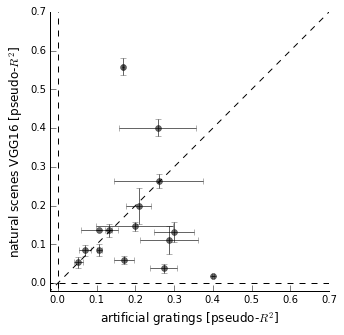

In [68]:
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
V4.simpleaxis(ax)
#ax.errorbar(x=np.array(art_pseudo_R2['mean']), y=np.array(nat_pseudo_R2['mean']), 
#             xerr=np.array(art_pseudo_R2['std']), yerr=np.array(nat_pseudo_R2['std']), fmt='go', alpha=0.3)
ax.errorbar(x=np.array(art_pseudo_R2['mean']), y=np.array(syn_pseudo_R2['mean']), 
             xerr=np.array(art_pseudo_R2['std']), yerr=np.array(syn_pseudo_R2['std']), fmt='ko', alpha=0.6)
ax.plot(np.linspace(-1., 1., 10), np.linspace(-1., 1., 10), 'k--')
ax.plot(np.linspace(-1., 1., 10), np.zeros(10), 'k--')
ax.plot(np.zeros(10), np.linspace(-1., 1., 10), 'k--')
ax.axis([-0.02, 0.7, -0.02, 0.7])
plt.xlabel('artificial gratings [pseudo-$R^2$]', fontsize=12)
plt.ylabel('natural scenes VGG16 [pseudo-$R^2$]', fontsize=12)

#plt.savefig('art_vs_nat_pseudoR2s.pdf', format='pdf')
plt.show()

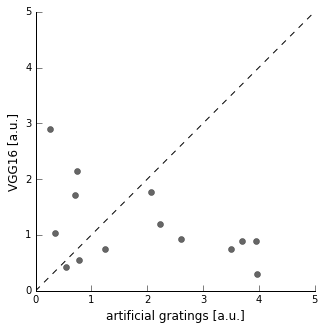

In [69]:
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
V4.simpleaxis(ax)
ax.plot(np.array(art_entropy), np.array(syn_entropy), 'ko', alpha=0.6)
ax.plot(np.linspace(0, 5, 10), np.linspace(0, 5, 10), 'k--')
#ax.plot(np.linspace(0, 5, 10), np.zeros(10), 'k--')
#ax.plot(np.zeros(10), np.linspace(-500, 3500, 10), 'k--')
ax.axis([0, 5, 0, 5])
plt.xlabel('artificial gratings [a.u.]', fontsize=12)
plt.ylabel('VGG16 [a.u.]', fontsize=12)

#plt.savefig('population_mod_depth.pdf', format='pdf')
plt.show()

In [52]:
syn_pseudo_R2['mean']

[0.55737328743026127,
 0.18894179203667832,
 0.11378399833809412,
 0.13227183688969668,
 0.047177100257969409,
 0.26351618913148495,
 0.087057116146126837,
 0.40530936243621757,
 0.037964713109712972,
 0.0657024976505097,
 0.07852439381793537,
 0.13671445688163503,
 0.020505832614903963,
 0.13637367929685046,
 0.12543689618788742]

In [163]:
def hsv_to_rgb(hue=0, sat=255, val=25):
    hsv = np.array([hue, sat, val])
    im = np.zeros((1,1,3))
    im[0, 0, :] = hsv
    im = im.astype(np.uint8)
    rgb = cv2.cvtColor(im, cv2.COLOR_HSV2RGB)
    return rgb[0, 0]

In [72]:
def show_tuning_as_color_strip(tune_art, tune_nat, tune_syn, neuron_name='neuron'):
    n_hues = tune_art.shape[0]
    im = 255. * np.ones((160, n_hues, 3))
        
    mx = np.max([tune_art.max(), tune_nat.max(), tune_syn.max()])
    for hue, art_hue_fr in enumerate(tune_art):    
        norm_fr = art_hue_fr / mx * 255
        for row in range(40):
            im[row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)

    for hue, nat_hue_fr in enumerate(tune_nat):    
        norm_fr = nat_hue_fr / mx * 255
        for row in range(40):
            im[60+row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)
            
    for hue, syn_hue_fr in enumerate(tune_syn):    
        norm_fr = syn_hue_fr / mx * 255
        for row in range(40):
            im[120+row, hue, :] = hsv_to_rgb(hue=hue/2, sat=255, val=norm_fr)
        
    # Plot firing rate
    plt.imshow(im.astype(np.uint8), interpolation='none')
    plt.title(neuron_name)
    plt.axis('off')

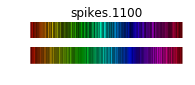

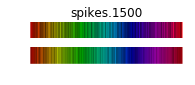

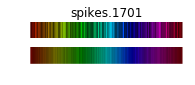

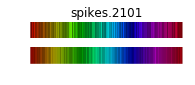

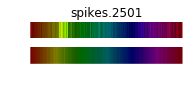

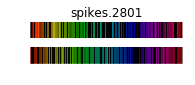

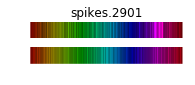

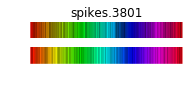

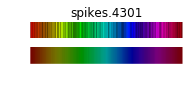

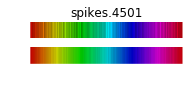

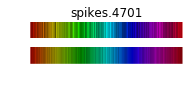

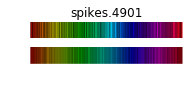

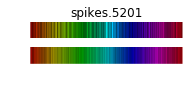

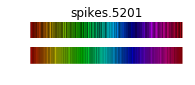

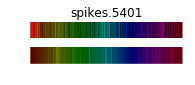

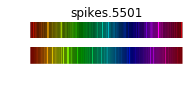

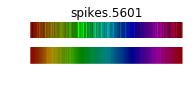

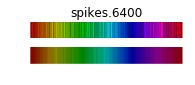

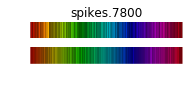

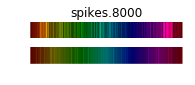

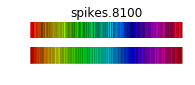

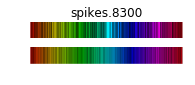

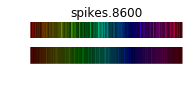

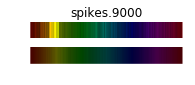

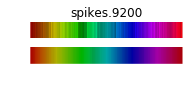

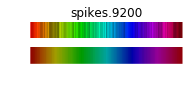

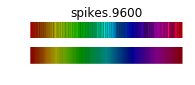

In [63]:
for neuron_id, neuron_name in enumerate(df_neurons['name']):    
    tune_art = df_fits_all['histogram_model'][neuron_id]['plain_predicted_spike_counts']
    tune_nat = df_fits_all['vggl7_model'][neuron_id]['plain_predicted_spike_counts']
    
    if np.mean(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']) - \
       2. * np.std(df_fits_all['vggl7_model'][neuron_id]['pseudo_R2']) > 0.:
        plt.figure()
        plt.subplot(121)
        show_tuning_as_color_strip(tune_art, tune_nat, neuron_name=neuron_name)

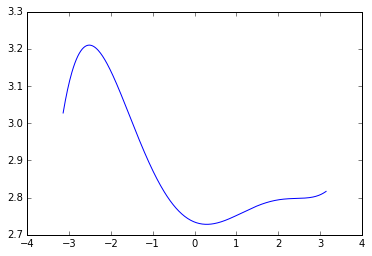

In [95]:
f_tmp = np.poly1d(np.polyfit(df_fits_all['art_model'][neuron_id]['hue'], 
                  df_fits_all['art_model'][neuron_id]['predicted_spike_counts'],
                  5))

# calculate new x's and y's
x_tmp = df_fits_all['histogram_model'][neuron_id]['plain_hue']
y_tmp = f_tmp(x_tmp)
plt.plot(x_tmp, y_tmp)
plt.show()